# Non-Stationary Noise Analysis of Fluorescence Data

This notebook performs non-stationary noise analysis on a linescan fluorescence experiment stored in the **OME-Zarr** format. The workflow is designed to analyze fluorescence measurements to detect single-channel activity of calcium (Ca²⁺) ions. The key objectives and steps are outlined below:

---

## Key Objectives
1. **Data Access and Preprocessing**:
   - Load fluorescence imaging data in OME-Zarr format.
   - Extract specific time, channel, and spatial dimensions for analysis.
   - Define a time domain based on acquisition parameters.

2. **Integrated Time Series Analysis**:
   - Divide the image into regions of interest along the spatial domain.
   - Compute integrated time series for each region to extract fluorescence dynamics.

3. **Non-Stationary Noise Analysis**:
   - Analyze the data for fluctuations indicative of Ca²⁺ single-channel activity.
   - Utilize a window-based approach to calculate variations in signal across time, focusing on potential channel opening times.

4. **Compare stimuli against neg- and pos- controls**:
   - Negative control is the non stimulated case.
   - Mib is the stimulous condition.
   - Positive control is the iono condition.

---

## Intended Use Case
This analysis is particularly suited for fluorescence measurements of calcium ions with a putative channel opening time of **10 milliseconds**. The workflow aims to:
- Detect discrete channel events based on fluorescence fluctuations.
- Provide quantitative insights into calcium dynamics using statistical and noise analysis.

---

## Non-Stationary Noise Analysis

The **Non-Stationary Noise Analysis** focuses on assessing time-dependent variations in fluorescence signals to identify single-channel openings:

1. **Window-Based Signal Partitioning**:
   - The signal is divided into time windows of **50 milliseconds** (customizable based on the experiment).
   - Each window is processed to extract statistical noise characteristics.

2. **Noise Analysis Metrics**:
   - Compute variance and mean within each window to observe signal fluctuations.
   - Identify non-stationary behavior indicative of single-channel events.

3. **Single-Channel Activity**:
   - Leverage the calculated metrics to pinpoint transient fluorescence bursts.
   - Compare findings with the expected opening time of **10 milliseconds** for calcium channels.



## Install libraries

In [1]:
print("Installing necessary libraries...")
!pip install ome-zarr > /dev/null 2>&1
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Load libraries

In [2]:
import zarr
from ome_zarr.io import parse_url
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.stats import linregress
import math

## Functions

In [3]:
def process_ome_zarr_image(ome_zarr_path):
    """
    Processes an OME-Zarr image by extracting a specific slice, applying Gaussian blur, and retrieving metadata.

    Parameters:
    - ome_zarr_path (str): Path to the OME-Zarr file.

    Returns:
    - F5N_image_64x64 (ndarray): Processed 64x64 pixel image slice.
    - metadata (dict): Dictionary containing extracted metadata:
        - 'time_per_frame' (float or str): Total time per frame in milliseconds; returns a message if not found.
        - 'time_per_line' (float or str): Time per line in milliseconds; returns a message if not found.
        - 'pixel_size' (float or str): Pixel size; returns a message if not found.
        - 'time_domain' (ndarray or None): Time domain in seconds; None if time per frame is not found.
    """

    # Load the OME-Zarr file
    root = zarr.open(ome_zarr_path, mode="r")
   # Access the Fluo-5N image slice (T=0, C=3, Z=0)
    img = root["image_data"][0, 0, 0, :, :]  # Adjust indices as needed

    # Retrieve metadata
    image_metadata = root.attrs.get("image_metadata", {})

    # Initialize metadata dictionary
    metadata = {}

    # Extract time per frame
    time_per_frame = image_metadata.get('Axis 4 Parameters Common', {}).get('EndPosition', None)
    if time_per_frame is None:
        metadata['time_per_frame'] = 'Time Per Frame not found'
        metadata['time_per_line'] = 'Time Per Line not found'
        metadata['time_domain'] = None
    else:
        # Calculate time per line
        time_per_line = time_per_frame / img.shape[0]
        # Convert time to seconds
        time_domain = np.arange(img.shape[0]) * (time_per_line / 1000)
        metadata['time_per_frame'] = time_per_frame
        metadata['time_per_line'] = time_per_line
        metadata['time_domain'] = time_domain

    # Extract pixel size
    pixel_size = image_metadata.get('Reference Image Parameter', {}).get('WidthConvertValue', 'Pixel Size not found')
    metadata['pixel_size'] = pixel_size
    metadata['pixels_per_line'] =  img.shape[1]
    return img, metadata

def non_stationary_noise_analysis(time_series, time_per_line, window_duration_ms=100, PLOT = False):
    """
    Perform non-stationary noise analysis on a given time series.

    Parameters:
    - time_series (numpy array): Input time series data for analysis.
    - time_per_line (float): Time per line acquisition in milliseconds.
    - window_duration_ms (int, optional): Duration of the analysis window in milliseconds. Default is 100 ms.

    Returns:
    - results (dict): A dictionary containing mean values, variance values, and window indices.
    """
    # Calculate window size and number of windows
    window_size = int(window_duration_ms / time_per_line)  # Convert to number of samples
    num_windows = len(time_series) // window_size

    # Initialize lists to store results
    mean_values = []
    variance_values = []
    window_indices = []

    # Perform analysis for each window
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        window_data = time_series[start_idx:end_idx]

        # Calculate mean and variance for the window
        mean_values.append(np.mean(window_data))
        variance_values.append(np.var(window_data))
        window_indices.append(i * (window_duration_ms / 1000))  # Convert to seconds

    if(PLOT):
        # Plot results
        plt.figure(figsize=(12, 6))

        # Plot mean values
        plt.subplot(2, 1, 1)
        plt.plot(window_indices, mean_values, label="Mean", marker='o')
        plt.title("Non-Stationary Noise Analysis")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Mean Intensity")
        plt.grid(True)
        plt.legend()

        # Plot variance values
        plt.subplot(2, 1, 2)
        plt.plot(window_indices, variance_values, label="Variance", marker='o', color='orange')
        plt.xlabel("Time (seconds)")
        plt.ylabel("Variance")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Return results as a dictionary
    results = {
        "mean_values": mean_values,
        "variance_values": variance_values,
        "window_indices": window_indices
    }

    return results


def fit_and_plot_variance_with_background_binned_step(I, Var, region_label, I_step=1, Var_step=1):
    """
    Bin the data with specified steps, fit the variance model with background signal, and plot the results.

    Parameters:
        I (array): Mean intensities.
        Var (array): Variances.
        region_label (str): Label for the region being analyzed.
        I_step (float): Step size for binning in I.
        Var_step (float): Step size for binning in Var.

    Returns:
        dict: Fitted parameters {i, N, B} and their uncertainties.
    """
    # Bin the data with specified steps
    binned_I, binned_Var = bin_data_with_step(I, Var, I_step, Var_step)
    if (len(binned_I) < 5):
        return
    if (len(binned_Var) < 5):
        return


    #######

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(binned_I, binned_Var)

    # Initial guess and constraints
    p0 = [slope, np.mean(binned_I), np.min(binned_I)]
    bounds = ([0, 0, -np.inf], [np.inf, np.inf, np.inf])  # Non-negative a and b

    # Clean and preprocess data
    valid_mask = (binned_I > 0) & (binned_Var > 0)
    binned_I = binned_I[valid_mask]
    binned_Var = binned_Var[valid_mask]

    # Fit the model with increased maxfev
    popt, pcov = curve_fit(
        variance_model_with_background, 
        binned_I, 
        binned_Var, 
        p0=p0, 
        bounds=bounds, 
        maxfev=5000
    )


    #######
    
    # Fit the variance model with background
    #popt, pcov = curve_fit(variance_model_with_background, binned_I, binned_Var, p0=[1, 100, 0])
    i, N, B = popt
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of parameters

    # Generate data for the fitted curve
    I_fit = np.linspace(min(binned_I), max(binned_I), 100)
    Var_fit = variance_model_with_background(I_fit, i, N, B)

    # Plot the binned data and the fit
    plt.figure(figsize=(8, 6))
    plt.scatter(binned_I, binned_Var, label="Binned Data", color="blue", alpha=0.7)
    plt.plot(I_fit, Var_fit, label=f"Fit: Var = {i:.3f}*I - (I^2 / {N:.3f}) + {B:.3f}", color="red", linewidth=2)
    plt.title(f"Variance vs Intensity (Binned with step, {region_label})")
    plt.xlabel("Mean Intensity (I)")
    plt.ylabel("Variance (Var)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return fitted parameters and uncertainties
    return {"i": i, "N": N, "B": B, "i_std": perr[0], "N_std": perr[1], "B_std": perr[2]}

def bin_data_with_step(I, Var, I_step=1, Var_step=1):
    """
    Bin the data by averaging within specified steps of I and Var.

    Parameters:
        I (array): Mean intensities.
        Var (array): Variances.
        I_step (float): Step size for binning in I.
        Var_step (float): Step size for binning in Var.

    Returns:
        tuple: Binned mean intensities and variances.
    """
    # Ensure I and Var are numpy arrays
    I = np.array(I)
    Var = np.array(Var)

    # Create bins based on step sizes
    I_bins = np.floor(I / I_step).astype(int)
    unique_bins = np.unique(I_bins)

    # Calculate binned mean intensities and variances
    binned_I = []
    binned_Var = []
    for b in unique_bins:
        mask = I_bins == b
        if np.any(mask):  # Avoid empty bins
            binned_I.append(np.mean(I[mask]))
            binned_Var.append(np.mean(Var[mask]))

    return np.array(binned_I), np.array(binned_Var)

def variance_model_with_background(I, i, N, B):
    """
    Model equation for variance: Var = i*I - (I^2 / N) + B.

    Parameters:
        I (array): Mean intensities.
        i (float): Instensity scaling parameter.
        N (float): Parameter related to the Number of Channels.
        B (float): Background signal.

    Returns:
        array: Calculated variance for given intensities.
    """
    return i * I - (I**2) / N + B

def analyze_non_stationary_noise(F5N_image, metadata, apply_blur = False):
    """
    Analyze non-stationary noise in the provided image using the specified metadata.
    
    Parameters:
        F5N_image (numpy.ndarray): The input 2D fluorescence image.
        metadata (dict): Metadata containing keys like 'pixel_size', 'time_domain', and 'time_per_line'.
        acrosome_fwhm (float): Full-width half-maximum of the acrosome in nanometers. Default is 380.
    
    Returns:
        dict: Results containing the adjusted window start, width, and non-stationary noise analysis.
    """
    # Apply Gaussian blur if sigma_blur is provided
    if apply_blur is not False:
        acrosome_fwhm = 260 # nm (modelled using script 06_fluorescence_disk_simulation.ipynb)
        s = (acrosome_fwhm/2.35)/1000 # in microns
        spatial_blur = s/(metadata['pixel_size']*1) # blur one third the width of s
        # Set sigma only for the axis corresponding to rows (axis 0 in 2D array)
        sigma = [1, spatial_blur]  # Blur rows only, keep columns untouched
        F5N_image = gaussian_filter(F5N_image, sigma=sigma)
    
    # Compute variance and its derivative
    variance_values = np.var(F5N_image, axis=0)
    derivative_variance = np.gradient(variance_values)

    # Find the start of the window
    w_start = np.argmax(derivative_variance)

    # Compute the window width (convert to pixels)
    w_width = math.floor(0.8 / metadata['pixel_size'])

    # Adjust the start index if the window goes out of bounds
    if w_start + w_width > F5N_image.shape[1]:
        # Shift the window to the left to fit within bounds
        w_start = F5N_image.shape[1] - w_width
    if w_start < 0:
        # Shift the window to the right to fit within bounds
        w_start = 0

    # Ensure w_width does not exceed the remaining matrix domain
    w_width = min(w_width, F5N_image.shape[1] - w_start)

    nsna_image = F5N_image[:, w_start:(w_start+w_width)]

    time_series = nsna_image.sum(axis=1)
    # Extract time domain and time per line from metadata
    time_domain = metadata.get('time_domain')
    time_per_line = metadata.get('time_per_line')

    region_result = non_stationary_noise_analysis(time_series, time_per_line, window_duration_ms)

    # Display the first 32 rows and the selected window of columns
    plt.imshow(nsna_image[:150,:], cmap="gray")
    plt.title("First 100 lines of msna Image")
    plt.axis("off")
    plt.show()

    print(f"The adjusted index of the window start is: {w_start}")
    print(f"The adjusted window width in pixels is: {w_width}")

    # Return relevant results as a dictionary
    return {
        "region_result": region_result,
        "nsna_image": nsna_image
    }
def compute_and_plot_histogram_logscale(nsna_image, bins=256):
    """
    Compute and plot the histogram of the provided image with a logarithmic y-axis.
    
    Parameters:
        nsna_image (numpy.ndarray): The 2D image for which the histogram will be computed.
        bins (int): Number of bins for the histogram. Default is 256.
    """
    # Flatten the image to compute the histogram
    pixel_values = nsna_image.flatten()
    
    # Compute the histogram
    histogram, bin_edges = np.histogram(pixel_values, bins=bins, range=(pixel_values.min(), pixel_values.max()))
    
    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(bin_edges[:-1], histogram, width=np.diff(bin_edges), edgecolor="black", align="edge")
    plt.yscale("log")  # Set the y-axis to logarithmic scale
    plt.title("Histogram (Logarithmic Scale)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency (log scale)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()



## Analyze a single data file

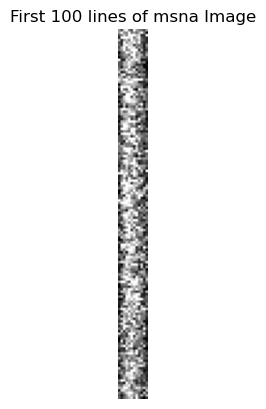

The adjusted index of the window start is: 16
The adjusted window width in pixels is: 12


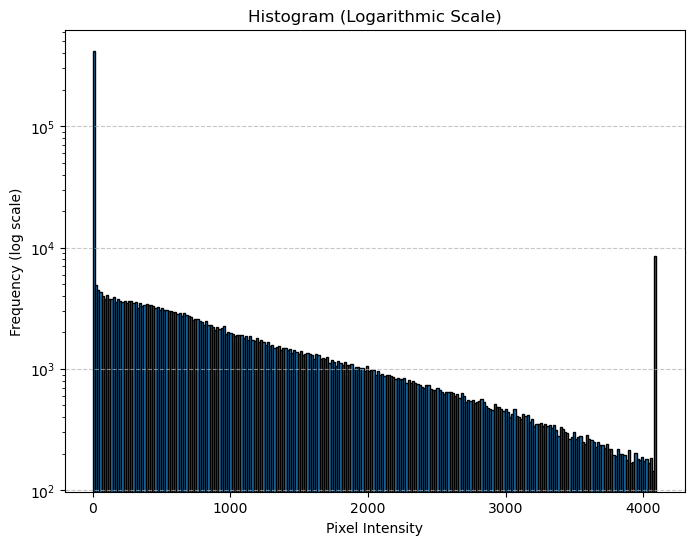

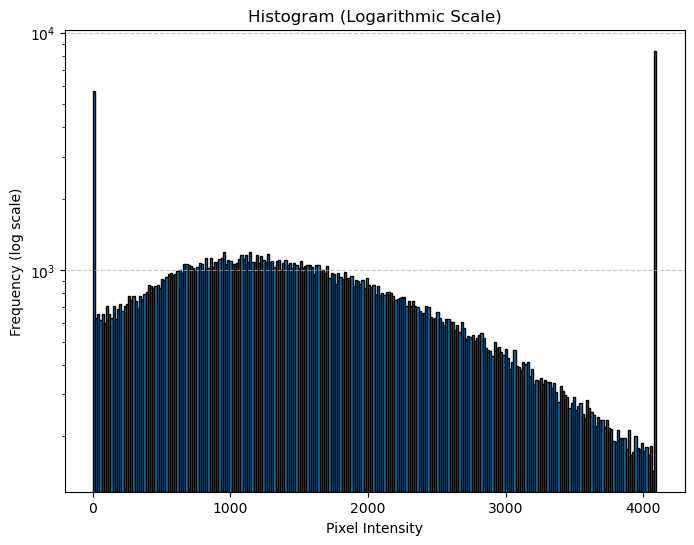

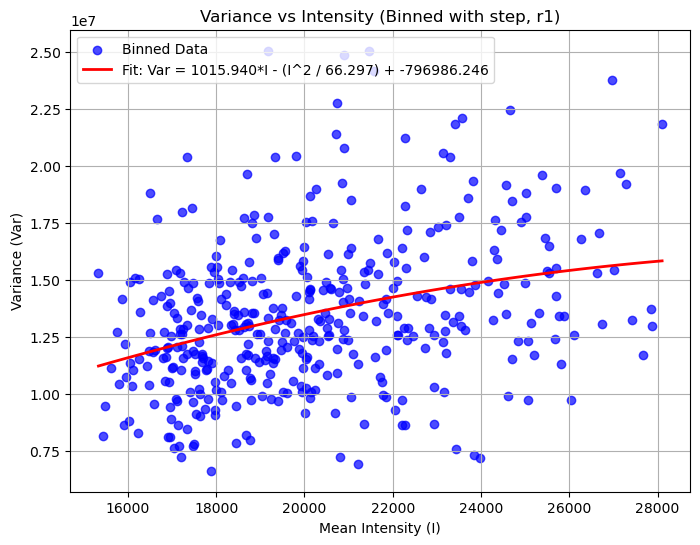

{'i': 1015.9398352852616,
 'N': 66.29683367262378,
 'B': -796986.2459323811,
 'i_std': 700.3933522683878,
 'N_std': 72.6788107379902,
 'B_std': 7302406.840940522}

In [4]:

#Pats

#directory_path = '/home/jovyan/LNMA/guerreroa/data/20241114'
#filename = '14_11_24_Exp2_TYH_mib_22C_120segundos.zarr'


#directory_path = '/home/jovyan/LNMA/guerreroa/data/20241120'
#filename = '20241120_CTRLXT_cabeza_16000L_4us_Zo25_128x128_R2_C1.zarr'
#filename =  '20241120_MBF15uMXYT_cabeza_4us_Zo25_16000L_128x128_R2_C1.zarr'
#filename = '20241120_IONO10uMXYT_cabeza_4us_Zo25_16000L_128x128_R2_C1.zarr'

directory_path = '/home/jovyan/LNMA/guerreroa/data/20241121'
filename = '20241121_MBF1uMXT_cabeza_16000L_4us_Zo25_128x128_R3_C2.zarr'

ome_zarr_path = os.path.join(directory_path, filename)

#Parameters
window_duration_ms = 50  # Time window in milliseconds
I_step= 1
Var_step= 1


F5N_image, metadata = process_ome_zarr_image(ome_zarr_path)
rs = analyze_non_stationary_noise(F5N_image, metadata, apply_blur = False)

# Pass the nsna_image obtained from the analyze_non_stationary_noise function
compute_and_plot_histogram_logscale(F5N_image)
compute_and_plot_histogram_logscale(rs["nsna_image"])

# Extract means and variances as NumPy arrays
means = np.array(rs["region_result"]["mean_values"]) #for region_result in accumulated_results]
variances = np.array(rs["region_result"]["variance_values"]) #for region_result in accumulated_results]

fit_and_plot_variance_with_background_binned_step(
        means, variances, "r1", I_step, Var_step
    ) 

## Analyze all files in a folder

Processing file: 20241122_MBF30uMXT5Min_Head_5000L_PHC_4us_Zo25_128x128_R4_C1.zarr


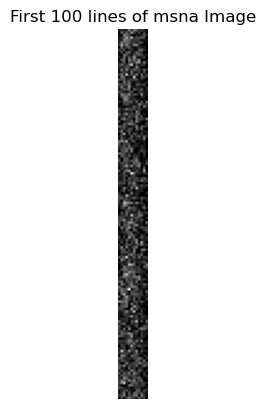

The adjusted index of the window start is: 3
The adjusted window width in pixels is: 12


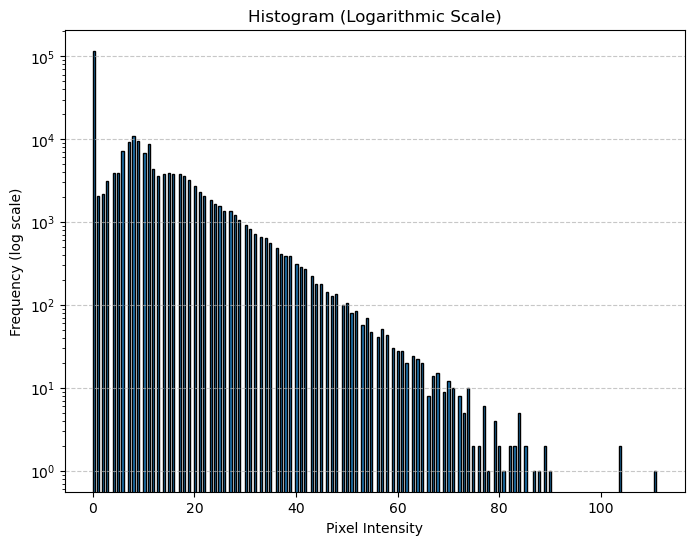

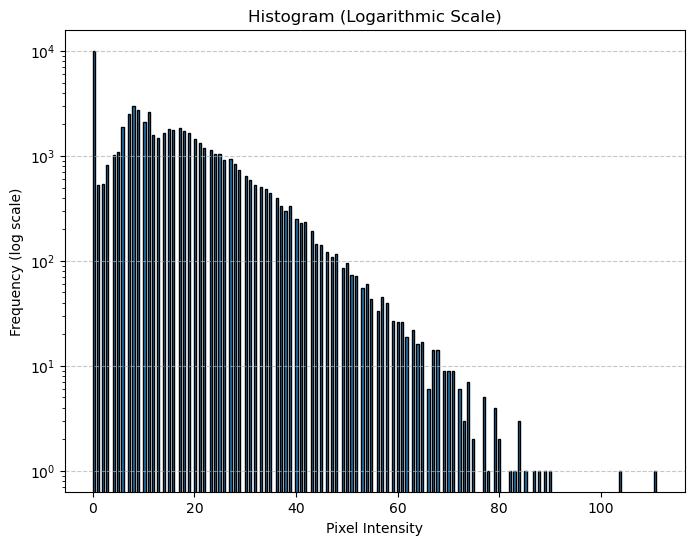

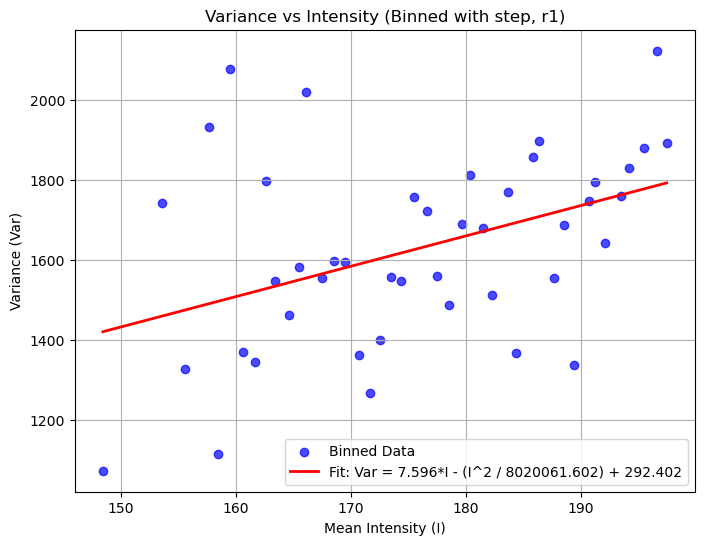

Processing file: 20241122_CTRLXT_Head_5000L_ANAL_4us_Zo25_128x128_R4_C1.zarr


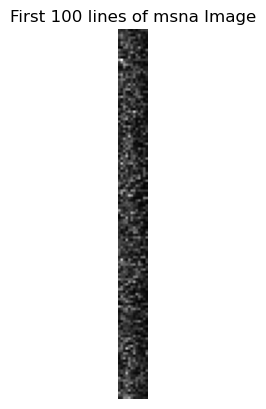

The adjusted index of the window start is: 7
The adjusted window width in pixels is: 12


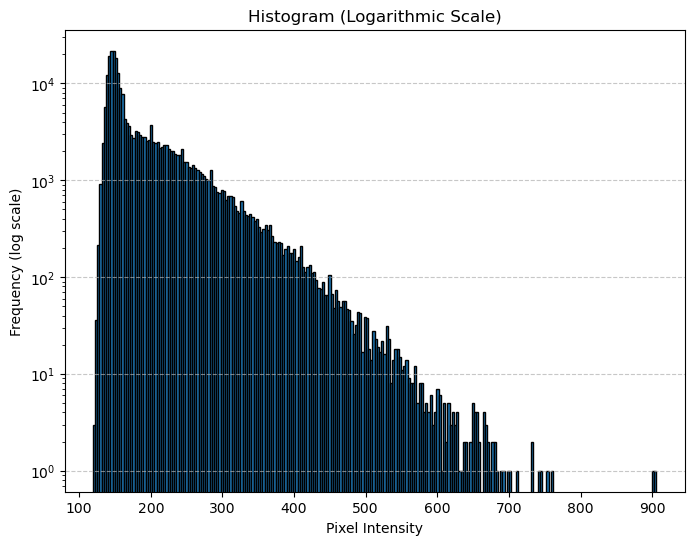

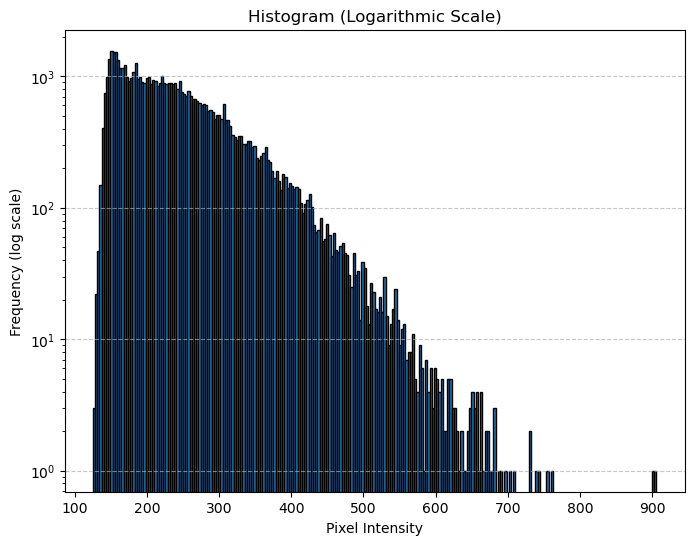

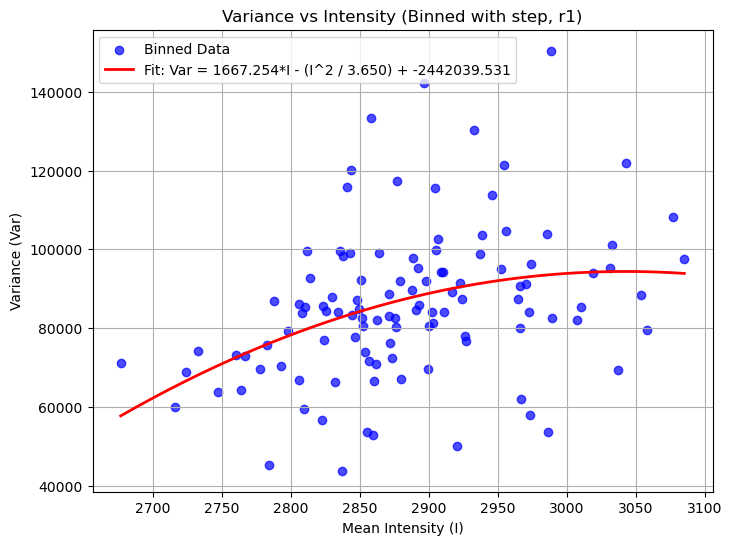

Skipping non-Zarr file: 20241122_MBF30uMXT5Min_Head_5000L_PHC_4us_Zo25_128x128_R4_C1.oib
Skipping non-Zarr file: 20241122_CTRLXT_Head_5000L_ANAL_4us_Zo25_128x128_R4_C1.oib
Skipping non-Zarr file: 20241122_CTRLXT_Head_5000L_PHC_INENDBG_4us_Zo25_128x128_R4_C1I.oib
Processing file: 20241122_CTRLXT_Head_5000L_PHC_4us_Zo25_128x128_R4_C1.zarr


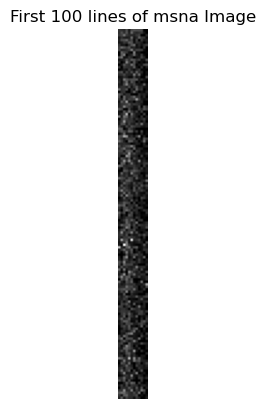

The adjusted index of the window start is: 14
The adjusted window width in pixels is: 12


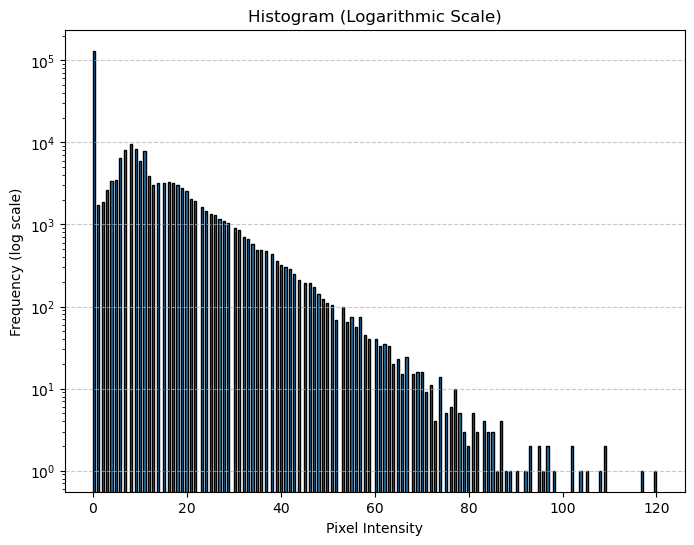

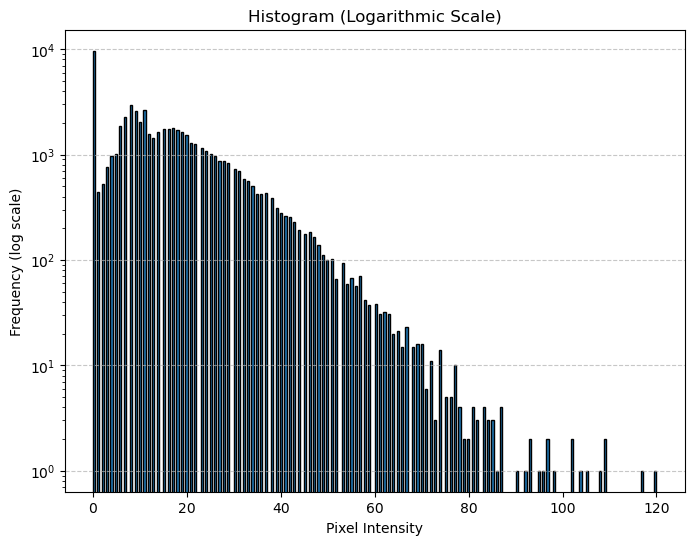

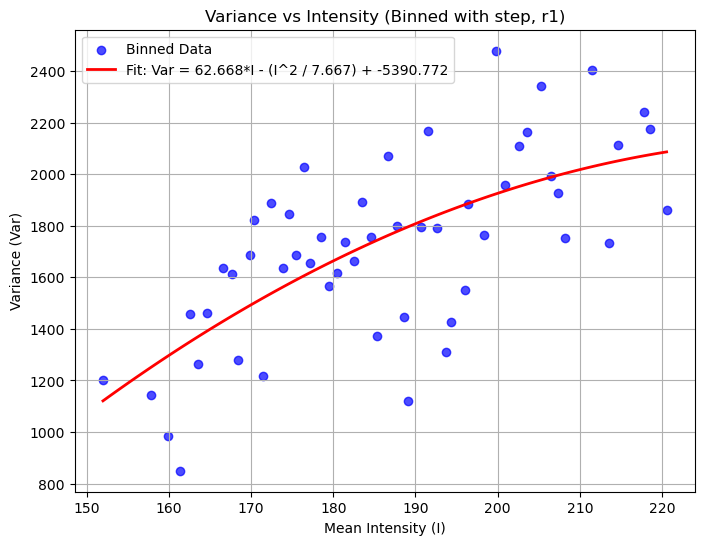

Skipping non-Zarr file: 20241122_MBF30uMXT5Min_IONO10uM3Min_Head_5000L_PHC_4us_Zo25_128x128_R4_C1.oib
Skipping non-Zarr file: processed_data.npy
Skipping non-Zarr file: 20241122_CTRLXT_Head_5000L_PHC_4us_Zo25_128x128_R4_C1.oib
Processing file: 20241122_CTRLXT_Head_5000L_PHC_INENDBG_4us_Zo25_128x128_R4_C1I.zarr


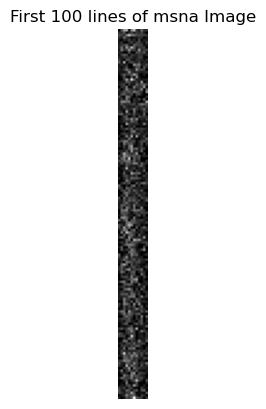

The adjusted index of the window start is: 5
The adjusted window width in pixels is: 12


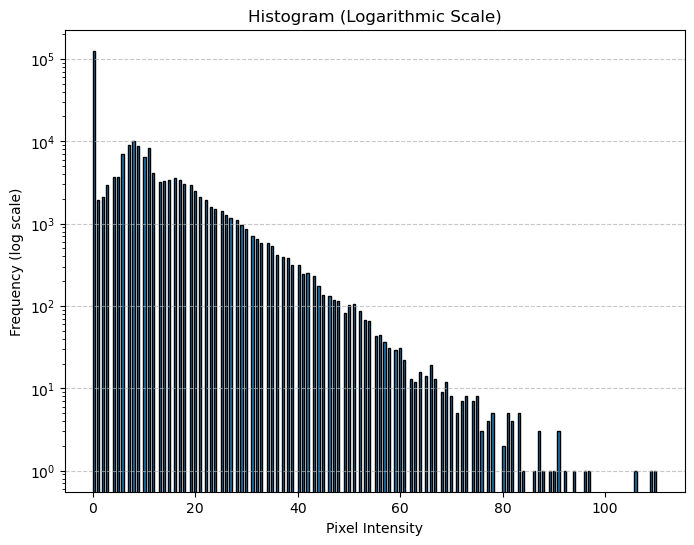

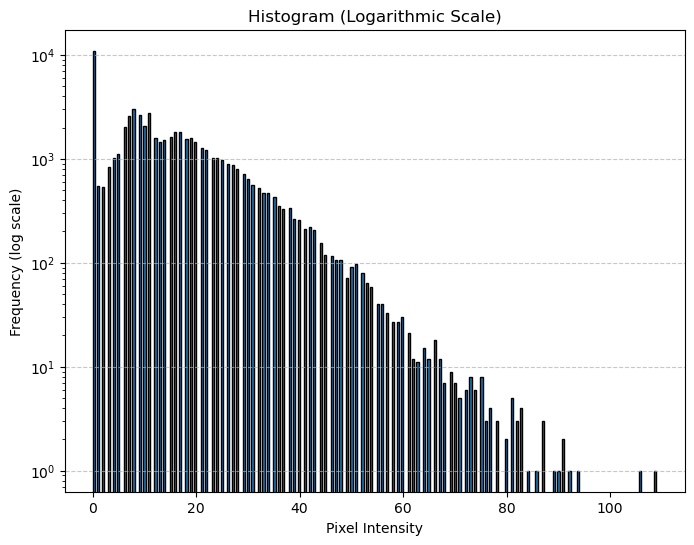

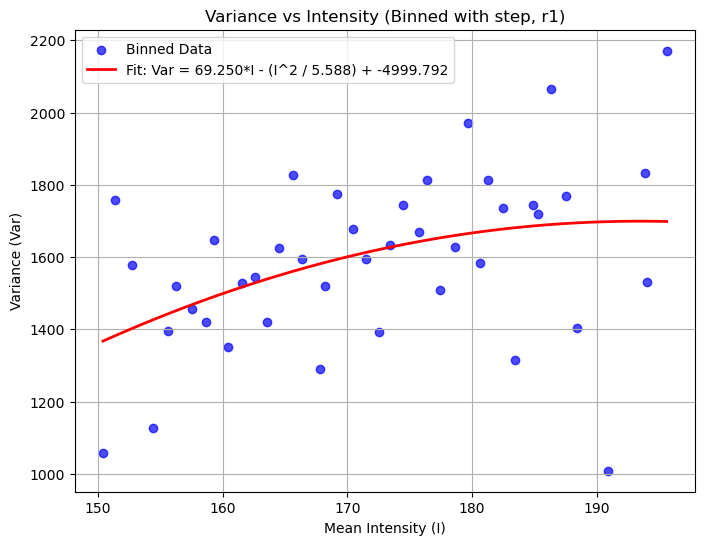

Processing file: 20241122_MBF30uMXT5Min_IONO10uM3Min_Head_5000L_PHC_4us_Zo25_128x128_R4_C1.zarr


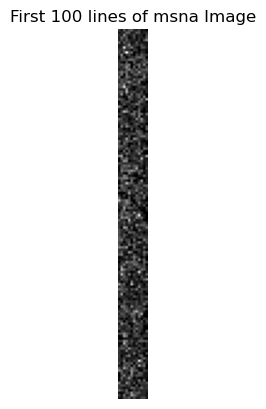

The adjusted index of the window start is: 0
The adjusted window width in pixels is: 12


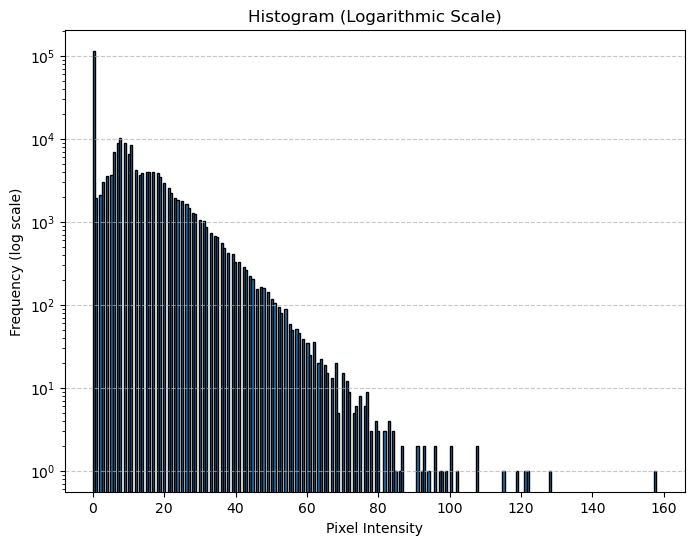

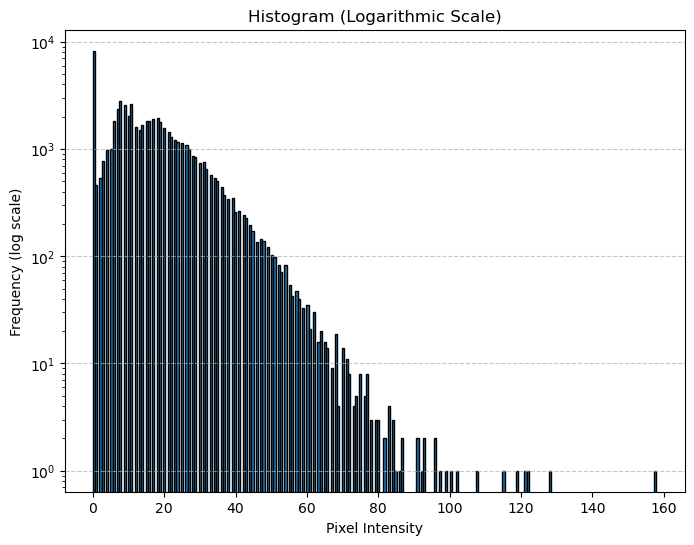

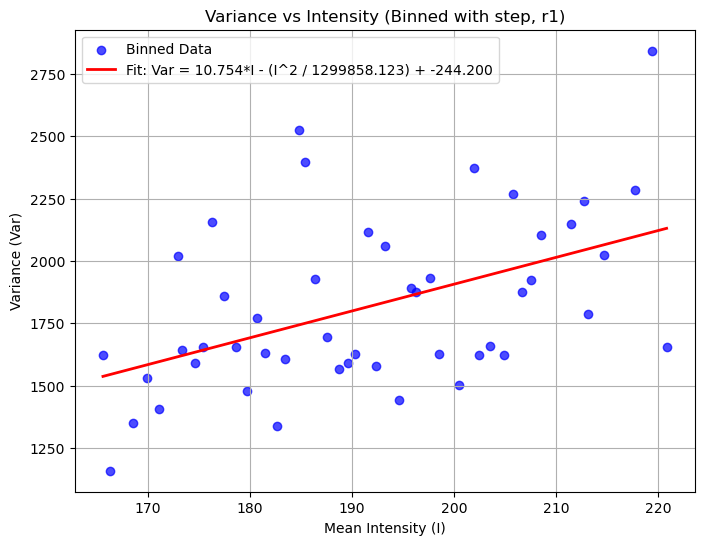

Processing file: 20241122_MBF30uMXT640Min_IONO10uM4Min_Head_5000L_ANAL_4us_Zo25_128x128_R4_C1.zarr


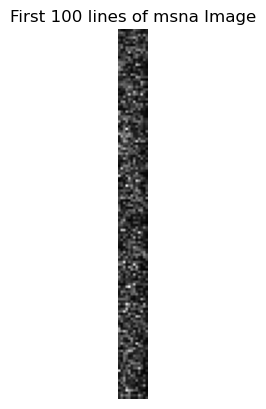

The adjusted index of the window start is: 0
The adjusted window width in pixels is: 12


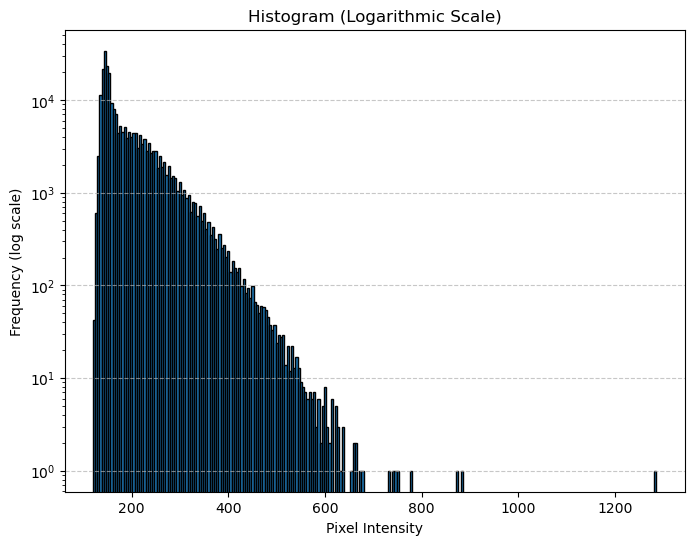

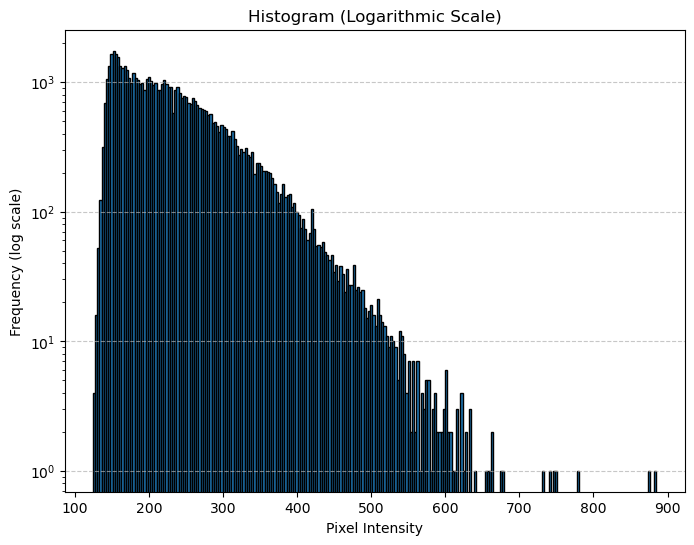

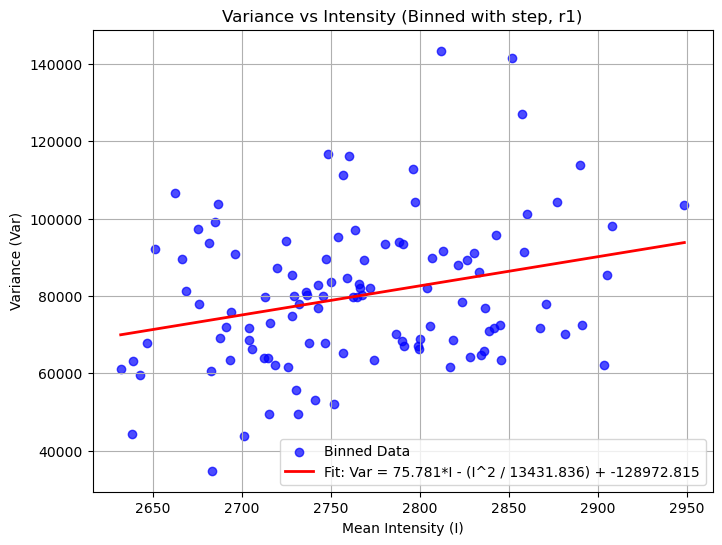

Skipping non-Zarr file: 20241122_MBF30uMXT640Min_IONO10uM4Min_Head_5000L_ANAL_4us_Zo25_128x128_R4_C1.oib
Processing file: 20241122_MBF30uMXT640Min_Head_5000L_ANAL_4us_Zo25_128x128_R4_C1.zarr


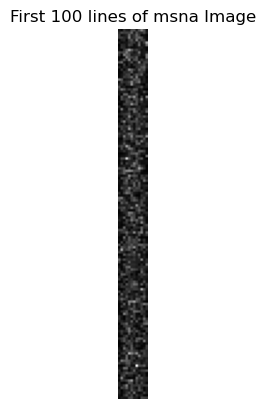

The adjusted index of the window start is: 1
The adjusted window width in pixels is: 12


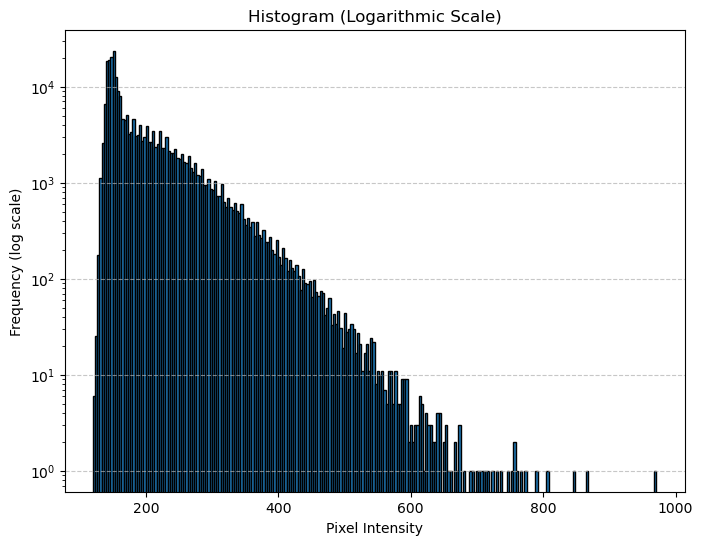

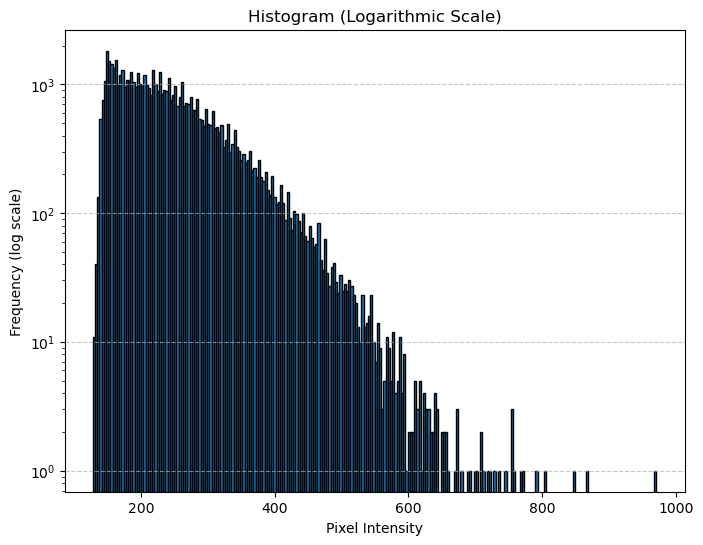

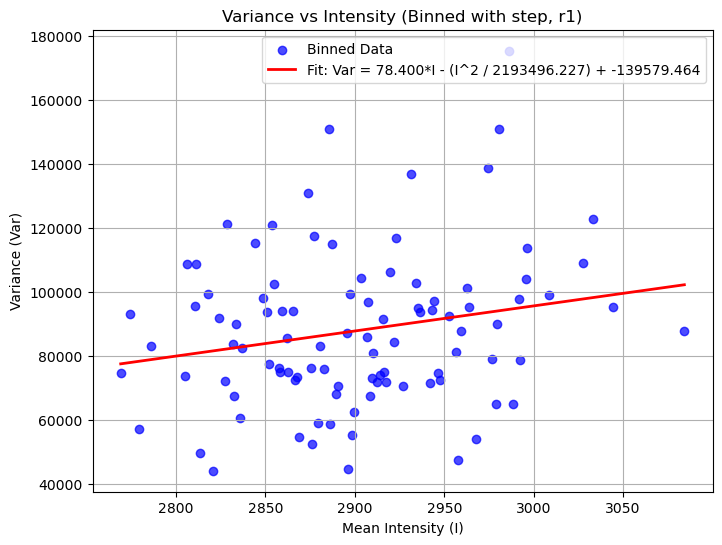

Skipping non-Zarr file: 20241122_MBF30uMXT640Min_Head_5000L_ANAL_4us_Zo25_128x128_R4_C1.oib
Processed data saved to /home/jovyan/LNMA/guerreroa/data/20241122/processed_data.npy


In [5]:
directory_path = '/home/jovyan/LNMA/guerreroa/data/20241122'

#Parameters
window_duration_ms = 50  # Time window in milliseconds
I_step= 1
Var_step= 1


# Initialize a list to store all data_dicts
data_list = []

# Iterate over all files in the directory
for file_name in os.listdir(directory_path):
    # Construct the original full path
    ome_zarr_path = os.path.join(directory_path, file_name)
    
    # Skip files that do not have .zarr extension
    if not ome_zarr_path.endswith('.zarr'):
        print(f"Skipping non-Zarr file: {file_name}")
        continue
    
    print(f"Processing file: {file_name}")
    
    # Process the Zarr file
    F5N_image, metadata = process_ome_zarr_image(ome_zarr_path)
    
    # Analyze the non-stationary noise
    rs = analyze_non_stationary_noise(F5N_image, metadata, apply_blur=False)
    
    # Compute and plot histograms for the raw image and the processed nsna_image
    compute_and_plot_histogram_logscale(F5N_image)
    compute_and_plot_histogram_logscale(rs["nsna_image"])
    
    # Extract mean and variance values
    means = np.array(rs["region_result"]["mean_values"])
    variances = np.array(rs["region_result"]["variance_values"])
    
    # Fit and plot variance with background binned step
    fit_and_plot_variance_with_background_binned_step(
        means, variances, "r1", I_step, Var_step
    )
    
    # Create a dictionary with the results for this file
    data_dict = {
        "file_name": file_name,
        "region_result": rs["region_result"],
        "nsna_image": rs["nsna_image"]
    }
    
    # Append the data_dict to the list
    data_list.append(data_dict)

# Save the accumulated data_list as a NumPy file
output_file = os.path.join(directory_path, "processed_data.npy")
np.save(output_file, data_list)

print(f"Processed data saved to {output_file}")

## Load and analyze the processed_data.npy file

Loaded data from /home/jovyan/LNMA/guerreroa/data/20241122/processed_data.npy.
File: 20241122_MBF30uMXT5Min_Head_5000L_PHC_4us_Zo25_128x128_R4_C1.zarr


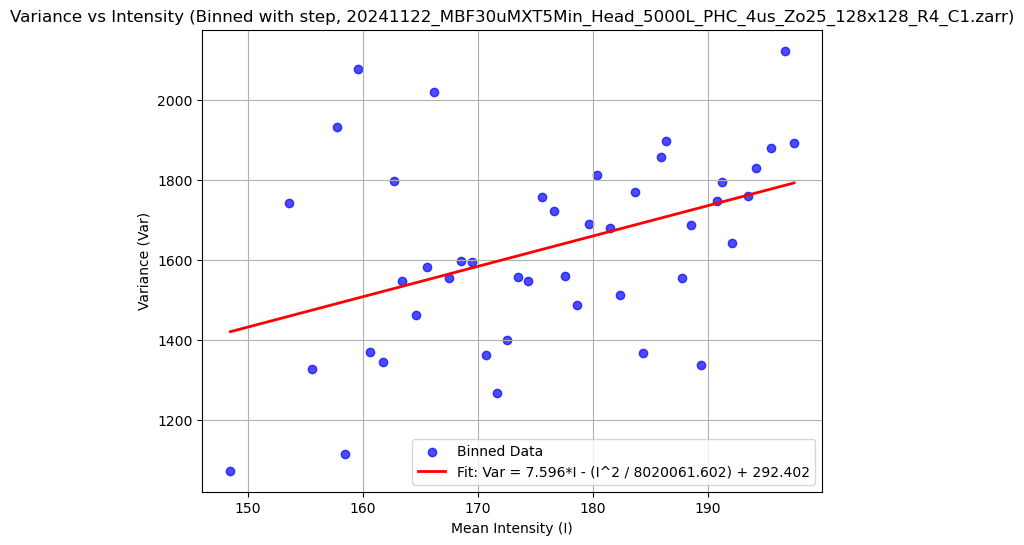

Region Result Keys: dict_keys(['mean_values', 'variance_values', 'window_indices'])
nsna_image Shape: (5000, 12)
File: 20241122_CTRLXT_Head_5000L_ANAL_4us_Zo25_128x128_R4_C1.zarr


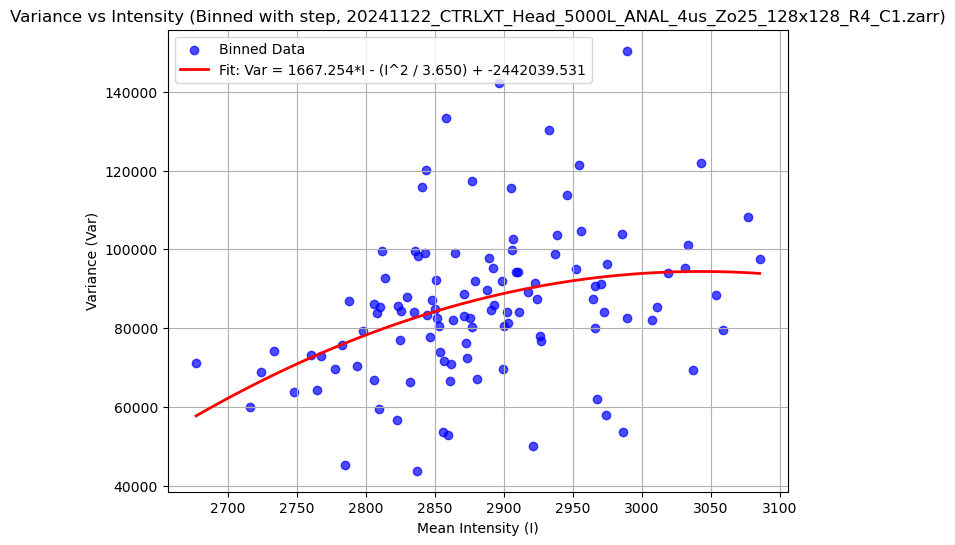

Region Result Keys: dict_keys(['mean_values', 'variance_values', 'window_indices'])
nsna_image Shape: (5000, 12)
File: 20241122_CTRLXT_Head_5000L_PHC_4us_Zo25_128x128_R4_C1.zarr


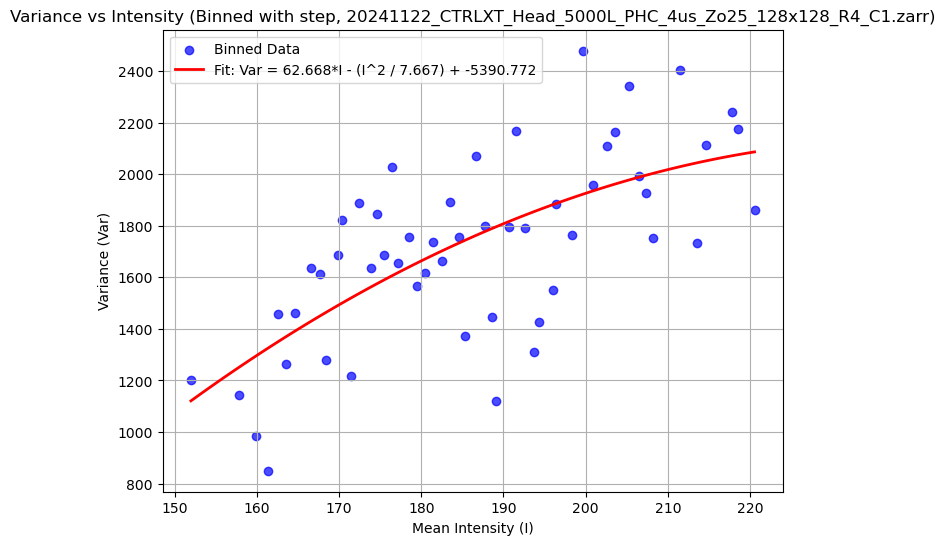

Region Result Keys: dict_keys(['mean_values', 'variance_values', 'window_indices'])
nsna_image Shape: (5000, 12)
File: 20241122_CTRLXT_Head_5000L_PHC_INENDBG_4us_Zo25_128x128_R4_C1I.zarr


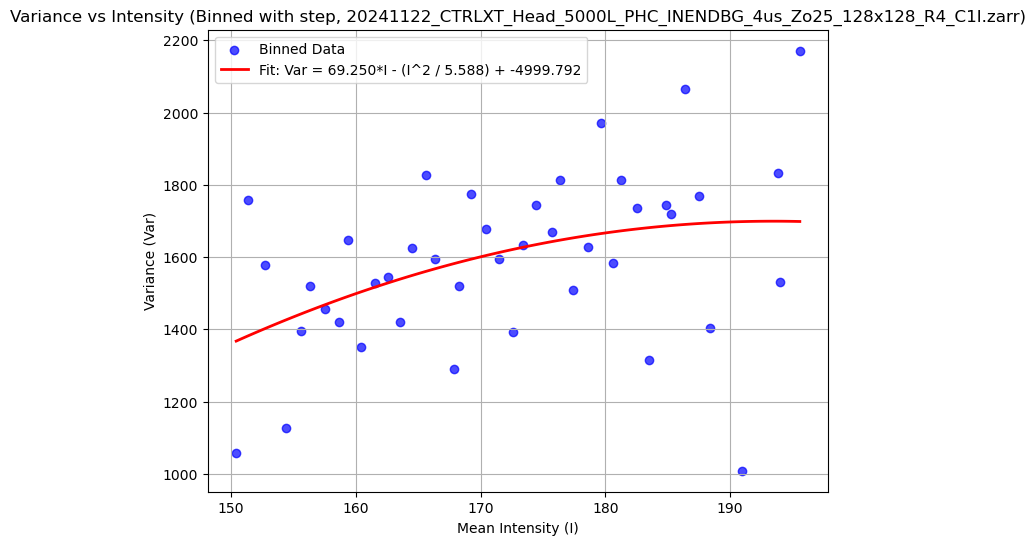

Region Result Keys: dict_keys(['mean_values', 'variance_values', 'window_indices'])
nsna_image Shape: (5000, 12)
File: 20241122_MBF30uMXT5Min_IONO10uM3Min_Head_5000L_PHC_4us_Zo25_128x128_R4_C1.zarr


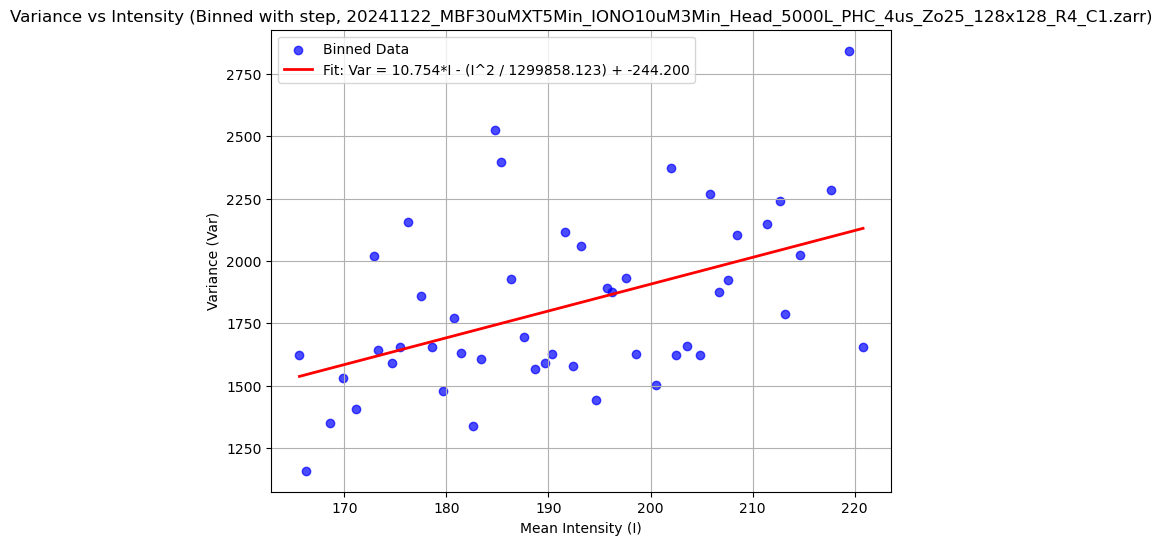

Region Result Keys: dict_keys(['mean_values', 'variance_values', 'window_indices'])
nsna_image Shape: (5000, 12)
File: 20241122_MBF30uMXT640Min_IONO10uM4Min_Head_5000L_ANAL_4us_Zo25_128x128_R4_C1.zarr


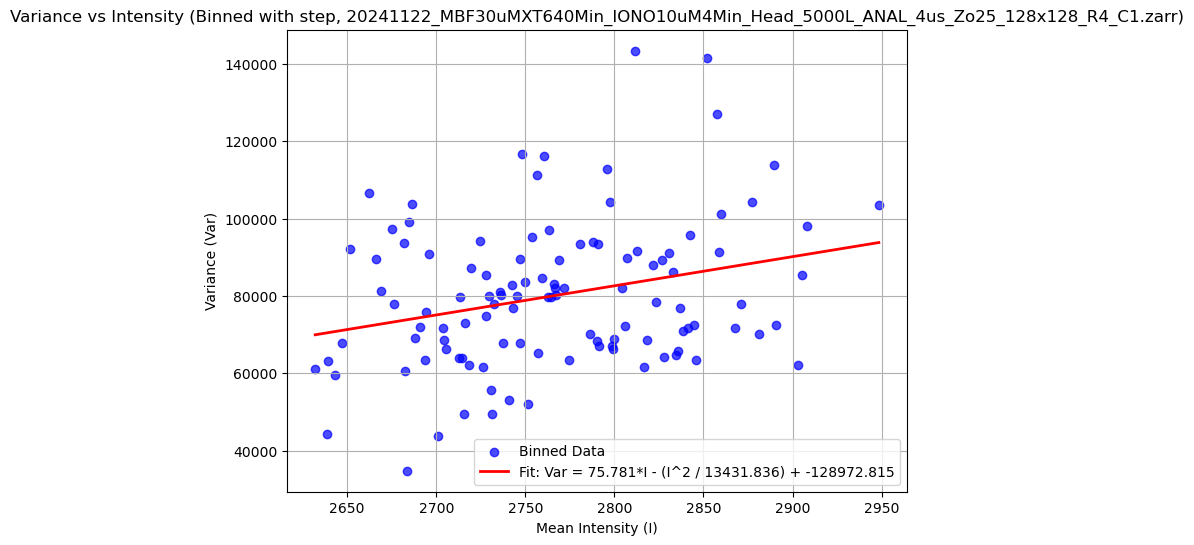

Region Result Keys: dict_keys(['mean_values', 'variance_values', 'window_indices'])
nsna_image Shape: (5000, 12)
File: 20241122_MBF30uMXT640Min_Head_5000L_ANAL_4us_Zo25_128x128_R4_C1.zarr


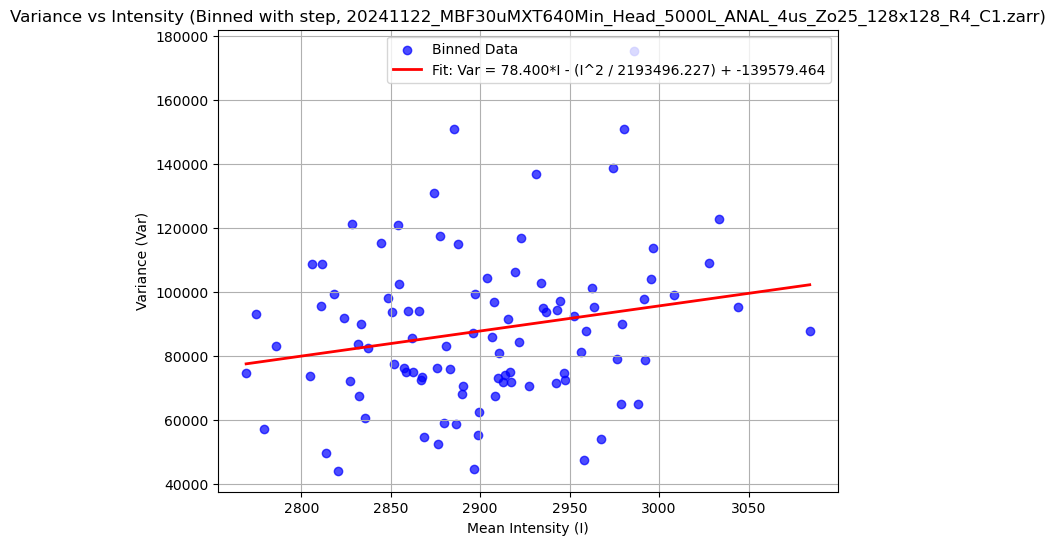

Region Result Keys: dict_keys(['mean_values', 'variance_values', 'window_indices'])
nsna_image Shape: (5000, 12)


In [6]:

#Parameters
I_step= 1
Var_step= 1


# Load the data list
try:
    data_list = np.load(output_file, allow_pickle=True)
    print(f"Loaded data from {output_file}.")
    
    # Access and iterate through each data_dict
    for data_dict in data_list:
        file_name = data_dict["file_name"]
        region_result = data_dict["region_result"]
        nsna_image = data_dict["nsna_image"]
        
        print(f"File: {file_name}")
        means = np.array(region_result["mean_values"])
        variances = np.array(region_result["variance_values"])
    
        fit_and_plot_variance_with_background_binned_step(
            means, variances, file_name, I_step, Var_step
            )
        
        # Example: Print file name and keys in region_result

        print(f"Region Result Keys: {region_result.keys()}")
        print(f"nsna_image Shape: {nsna_image.shape}")
except Exception as e:
    print(f"Error loading file: {e}")